# Participation Rates Explain Top-Level Group Disparities: Why Women Are Not Worse Than Men at Chess

## Imports

In [1]:
import math
from typing import TypeAlias

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy import stats
from scipy.stats import genpareto, rv_continuous

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 150)

from pathlib import Path

ROOT_PATH = Path('.')
DATA_PATH = ROOT_PATH / 'data'
if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True)

## Notes

- Data sources can be found in the supplementary notebook `2020-chess-statistics.ipynb`
- I will be using standard deviation ($\sigma$) as a proxy for skill, interest in chess, rating ...etc.
- I will be mixing American statistics with FIDE world statistics, mainly for computation time.
  - The important point is that the female participation rate is around 10% of the male numbers.
- Although I use the generalized pareto distribution (GPD), the real distribution is somewhere between
  a generalized extreme value (GEV) distribution and the GPD.
  - This is because I take the top n values, while GPD uses peaks over threshold, and GEV uses maxima.
  - It may be fruitful to find an equation that best represents the actual distribution.
  - However, the GPD is close enough to work.

## Modeling Active Chess Players
- There are 49.5 million americans who have the interest in chess to become active chess players. What does this
  distribution look like?

In [2]:
def get_top_n_samples(n_pop: int, top_n: int, n_trials: int) -> np.ndarray:
    if n_pop < top_n:
        raise ValueError('n_pop must be greater than top_n')
    rng = np.random.default_rng(42)
    trials = np.sort(rng.standard_normal((n_trials, n_pop)), axis=1)
    return trials[:, -top_n:]

In [3]:
# One trial to save computation time.
interest = get_top_n_samples(n_pop=330_000_000, top_n=49_500_000, n_trials=1)

In [4]:
# Subsample to save computation time.
interest_sub = interest[:, ::1000]
interest.shape, interest_sub.shape

((1, 49500000), (1, 49500))

In [5]:
interest_flat = interest_sub.flatten()
interest_flat.shape

(49500,)

In [6]:
par_bounds = [(-5, 5), (0, 5), (-5, 5)]
par_fit = stats.fit(genpareto, interest_flat, par_bounds)
interest_dist = genpareto(*par_fit.params)
par_fit.params

c:\Users\viami\miniforge3\envs\temp10\lib\site-packages\scipy\stats\_distn_infrastructure.py:2357: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


FitParams(c=-0.15013281005681, loc=1.03649928973427, scale=0.5990221108128373)

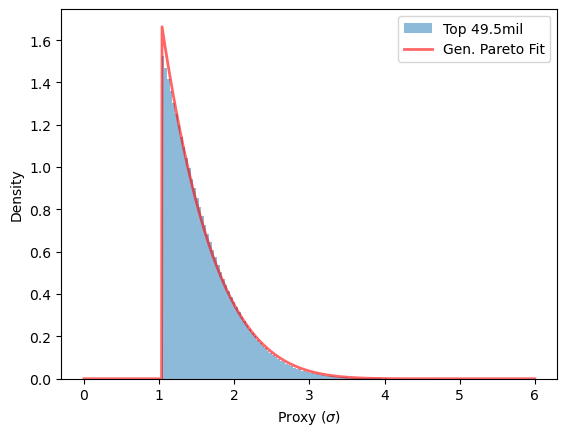

In [7]:
x = np.linspace(0, 6, 1000)
fig, ax = plt.subplots()
ax.hist(interest_flat, bins=100, density=True, alpha=0.5, label='Top 49.5mil')
ax.plot(x, interest_dist.pdf(x), 'r-', lw=2, alpha=0.6, label='Gen. Pareto Fit')
ax.set_xlabel('Proxy ($\sigma$)')
ax.set_ylabel('Density')
ax.legend()

### Draw from active chess player distribution

- If using 9:1 ratio, 4.95 million women, 44.55 million men.
- If using 8.2% of active population, then 4.059 million women, 45.405 million men.
- Top chess players have extreme interest in chess. There are about 360k rated players. Let's
  see what the resulting ratio is when we draw the top 360k women vs the top 360k men.


In [88]:
def get_top_n_with_dist(
    dist: rv_continuous, n_pop: int, top_n: int, n_trials: int = 1
) -> np.ndarray:
    if n_pop < top_n:
        raise ValueError('n_pop must be greater than top_n')
    trials = np.sort(dist.rvs((n_trials, n_pop)), axis=1)
    return trials[:, -top_n:]


Bounds: TypeAlias = list[tuple[int, int]]


def fit_genpareto(data: np.ndarray, bounds: Bounds | None) -> rv_continuous:
    if bounds is None:
        bounds = [(-10, 10), (-10, 10), (-10, 10)]
    flat_data = data.flatten()
    # subset data to speed up fitting if there is too much data
    ten_to = np.log10(len(flat_data))
    if ten_to > 5:  # greater than 100k
        skip_n = math.ceil(10 ** (ten_to - 5))
        print(skip_n)
        flat_data = flat_data[::skip_n]
    par_fit = stats.fit(genpareto, flat_data, par_bounds)
    return genpareto(*par_fit.params)

In [131]:
n_trials = 1
n_active_w = 4_950_000
n_active_m = 44_550_000
# Testing 8.2% - note that 9:1 ratio seems to work better. Perhaps 9:1 is more reflective of
# reality in 2020?
# n_active_w = 4_059_000
# n_active_m = 45_405_000
n_rated = 362_493

rated_w = get_top_n_with_dist(interest_dist, n_active_w, n_rated, n_trials)
rated_m = get_top_n_with_dist(interest_dist, n_active_m, n_rated, n_trials)

In [132]:
par_bounds = [(-6, 6), (1, 6), (-6, 6)]
rated_w_dist = fit_genpareto(rated_w, par_bounds)
rated_m_dist = fit_genpareto(rated_m, par_bounds)

4
4


In [133]:
def get_n_w_m(w_data: np.ndarray, m_data: np.ndarray, top_n: int) -> tuple[float, float, float]:
    n_ms = []
    n_ws = []
    for trial in range(w_data.shape[0]):
        w_trial = w_data[trial, :]
        m_trial = m_data[trial, :]
        data = pl.concat(
            [
                pl.from_numpy(w_trial, 'x').with_columns(pl.lit(False).alias('man')),
                pl.from_numpy(m_trial, 'x').with_columns(pl.lit(True).alias('man')),
            ]
        )
        data = data.sort('x', descending=True).head(top_n)
        n_m = data['man'].sum()
        n_ms.append(n_m)
        n_ws.append(top_n - n_m)
    avg_ms = np.mean(n_ms)
    avg_ws = np.mean(n_ws)
    m_w_ratio = avg_ms / avg_ws
    return avg_ws, avg_ms, m_w_ratio

In [134]:
n_rated_w, n_rated_m, rated_m_w_ratio = get_n_w_m(rated_w, rated_m, n_rated)
n_rated_w, n_rated_m, rated_m_w_ratio

(36146.0, 326347.0, 9.028578542577325)

In [135]:
def plot_m_w_dists(w_data, w_dist, m_data, m_dist, ax=None):
    fig = None
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(m_data.flatten(), bins=100, density=True, alpha=0.5, label='Men')
    ax.plot(x, m_dist.pdf(x), '-', lw=2, alpha=0.6, label='M Fit')
    ax.hist(w_data.flatten(), bins=100, density=True, alpha=0.5, label='Women')
    ax.plot(x, w_dist.pdf(x), '-', lw=2, alpha=0.6, label='W Fit')
    ax.set_xlabel('Proxy ($\sigma$)')
    ax.set_ylabel('Density')
    ax.legend()
    return ax, fig

''

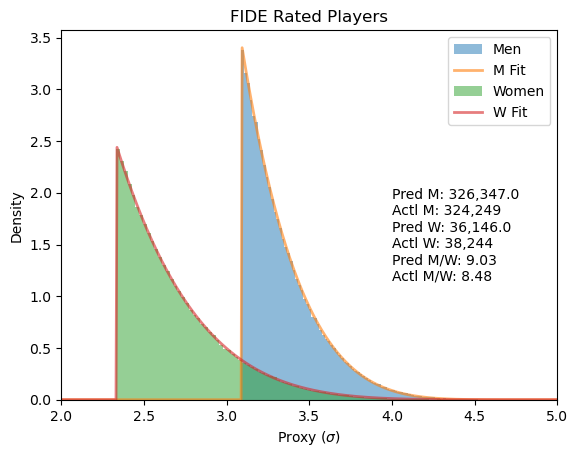

In [136]:
ax, fig = plot_m_w_dists(rated_w, rated_w_dist, rated_m, rated_m_dist)
ax.set_title('FIDE Rated Players')
ax.set_xlim([2, 5])
rated_info = f"""Pred M: {n_rated_m:,}
Actl M: 324,249
Pred W: {n_rated_w:,}
Actl W: 38,244
Pred M/W: {rated_m_w_ratio:0.2f}
Actl M/W: 8.48
"""
ax.text(4, 1, rated_info)
;

In [137]:
# Convert to integers for later
n_rated_w = round(n_rated_w)
n_rated_m = round(n_rated_m)

## Recap

- Remember, at this point all the data I have used are:
  - Approximate active women chess players in the US: 4,950,000 or 4,059,000
  - Approximate active men chess players in the US: 44,550,000 or 45,405,000
  - Number of rated FIDE players (world): 362,493

Notably, I have not used the actual numbers of FIDE rated men and women. The predictions are
quite close though, indicating that it's the ratio that matters, not the source of the original
data (American estimates vs world FIDE data).

## Predict the number and demographics of Grandmasters

Now I draw from the rated player distributions to predict the demographics of GMs
- The only data I will be adding on is the **total** number of GMs

In [138]:
n_trials = 100
n_gms = 1725
gm_w = get_top_n_with_dist(rated_w_dist, n_rated_w, n_gms, n_trials)
gm_m = get_top_n_with_dist(rated_m_dist, n_rated_m, n_gms, n_trials)

In [139]:
gm_w_dist = fit_genpareto(gm_w, par_bounds)
gm_m_dist = fit_genpareto(gm_m, par_bounds)

2


2


In [140]:
n_gm_w, n_gm_m, gm_m_w_ratio = get_n_w_m(gm_w, gm_m, n_gms)
n_gm_w, n_gm_m, gm_m_w_ratio

(27.31, 1697.69, 62.16367630904431)

''

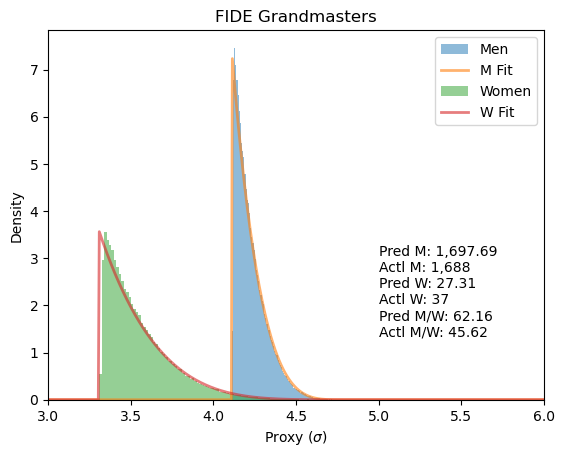

In [141]:
ax, fig = plot_m_w_dists(gm_w, gm_w_dist, gm_m, gm_m_dist)
ax.set_title('FIDE Grandmasters')
ax.set_xlim([3, 6])
gm_info = f"""Pred M: {n_gm_m:,}
Actl M: 1,688
Pred W: {n_gm_w:,}
Actl W: 37
Pred M/W: {gm_m_w_ratio:0.2f}
Actl M/W: 45.62
"""
ax.text(5, 1, gm_info)
;

## Conclusions
1. Women are not innately worse than men at chess.
2. Under extreme value theory, early participation differences balloon into major differences at
   the highest levels.

## Not convinced?
Here I will go from US players, to players rated over 2400, to GMs.


### Titled Players

In [142]:
n_trials = 100
n_titled = 15685
titled_w = get_top_n_with_dist(rated_w_dist, n_rated_w, n_titled, n_trials)
titled_m = get_top_n_with_dist(rated_m_dist, n_rated_m, n_titled, n_trials)

In [143]:
titled_w_dist = fit_genpareto(titled_w, par_bounds)
titled_m_dist = fit_genpareto(titled_m, par_bounds)

16
16


In [144]:
n_titled_w, n_titled_m, titled_m_w_ratio = get_n_w_m(titled_w, titled_m, n_titled)
n_titled_w, n_titled_m, titled_m_w_ratio

(205.98, 15479.02, 75.14816972521605)

''

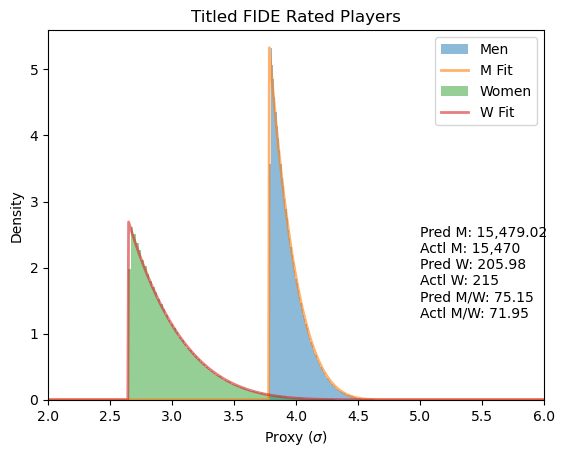

In [145]:
ax, fig = plot_m_w_dists(titled_w, titled_w_dist, titled_m, titled_m_dist)
ax.set_title('Titled FIDE Rated Players')
ax.set_xlim([2, 6])
titled_info = f"""Pred M: {n_titled_m:,}
Actl M: 15,470
Pred W: {n_titled_w:,}
Actl W: 215
Pred M/W: {titled_m_w_ratio:0.2f}
Actl M/W: 71.95
"""
ax.text(5, 1, titled_info)
;

### US Players

US players make for an interesting test because they aren't necessarily the top rated players in the pool
of rated players. Therefore...

IMPORTANT: we don't expect the numbers to be accurate for US players

In [158]:
n_trials = 100
n_us = 6690
us_w = get_top_n_with_dist(rated_w_dist, n_rated_w, n_us, n_trials)
us_m = get_top_n_with_dist(rated_m_dist, n_rated_m, n_us, n_trials)

In [159]:
us_w_dist = fit_genpareto(us_w, par_bounds)
us_m_dist = fit_genpareto(us_m, par_bounds)

7
7


In [148]:
n_us_w, n_us_m, us_m_w_ratio = get_n_w_m(us_w, us_m, n_us)
n_us_w, n_us_m, us_m_w_ratio

(93.53, 6596.47, 70.52785202608788)

''

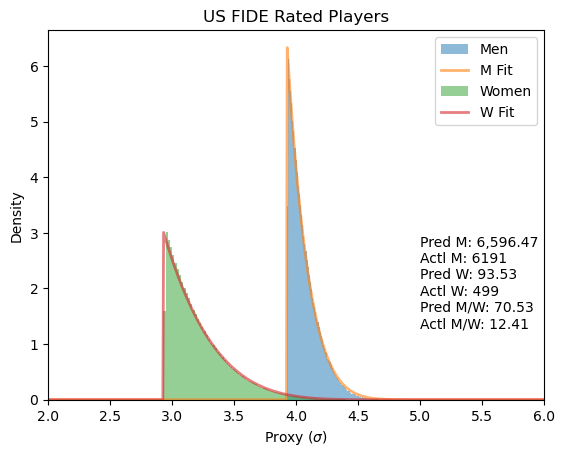

In [149]:
ax, fig = plot_m_w_dists(us_w, us_w_dist, us_m, us_m_dist)
ax.set_title('US FIDE Rated Players')
ax.set_xlim([2, 6])
us_info = f"""Pred M: {n_us_m:,}
Actl M: 6191
Pred W: {n_us_w:,}
Actl W: 499
Pred M/W: {us_m_w_ratio:0.2f}
Actl M/W: 12.41
"""
ax.text(5, 1, us_info)
;

### Players With Rating Over 2400

In [150]:
n_trials = 100
n_gt24 = 3112
gt24_w = get_top_n_with_dist(rated_w_dist, n_rated_w, n_gt24, n_trials)
gt24_m = get_top_n_with_dist(rated_m_dist, n_rated_m, n_gt24, n_trials)

In [151]:
gt24_w_dist = fit_genpareto(gt24_w, par_bounds)
gt24_m_dist = fit_genpareto(gt24_m, par_bounds)

4
4


In [152]:
n_gt24_w, n_gt24_m, gt24_m_w_ratio = get_n_w_m(gt24_w, gt24_m, n_gt24)
n_gt24_w, n_gt24_m, gt24_m_w_ratio

(46.9, 3065.1, 65.35394456289978)

''

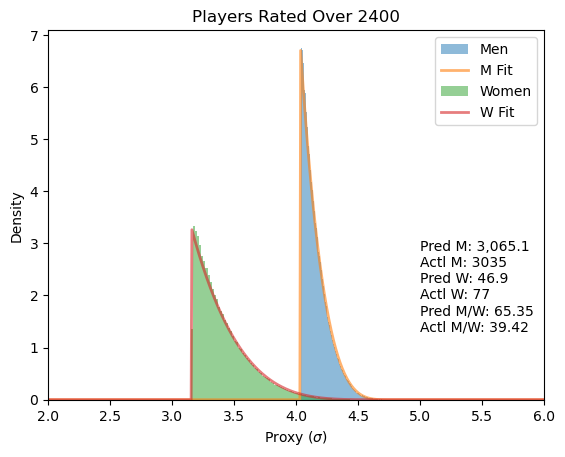

In [153]:
ax, fig = plot_m_w_dists(gt24_w, gt24_w_dist, gt24_m, gt24_m_dist)
ax.set_title('Players Rated Over 2400')
ax.set_xlim([2, 6])
gt24_info = f"""Pred M: {n_gt24_m:,}
Actl M: 3035
Pred W: {n_gt24_w:,}
Actl W: 77
Pred M/W: {gt24_m_w_ratio:0.2f}
Actl M/W: 39.42
"""
ax.text(5, 1, gt24_info)
;

### Top 1000

In [154]:
n_trials = 100
n_top1k = 1000
top1k_w = get_top_n_with_dist(rated_w_dist, n_rated_w, n_top1k, n_trials)
top1k_m = get_top_n_with_dist(rated_m_dist, n_rated_m, n_top1k, n_trials)

In [155]:
top1k_w_dist = fit_genpareto(top1k_w, par_bounds)
top1k_m_dist = fit_genpareto(top1k_m, par_bounds)

In [156]:
n_top1k_w, n_top1k_m, top1k_m_w_ratio = get_n_w_m(top1k_w, top1k_m, n_top1k)
n_top1k_w, n_top1k_m, top1k_m_w_ratio

(16.67, 983.33, 58.98800239952009)

''

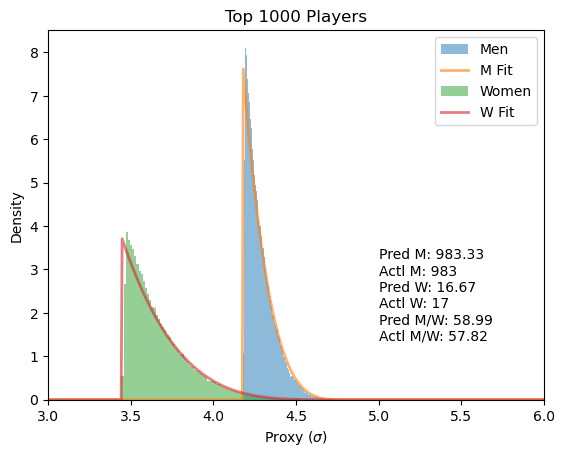

In [157]:
ax, fig = plot_m_w_dists(top1k_w, top1k_w_dist, top1k_m, top1k_m_dist)
ax.set_title('Top 1000 Players')
ax.set_xlim([3, 6])
top1k_info = f"""Pred M: {n_top1k_m:,}
Actl M: 983
Pred W: {n_top1k_w:,}
Actl W: 17
Pred M/W: {top1k_m_w_ratio:0.2f}
Actl M/W: 57.82
"""
ax.text(5, 1, top1k_info)
;